# Transfer Learning tutorial from PyTorch

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from pathlib import Path

In [2]:
plt.ion()

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = Path('./hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

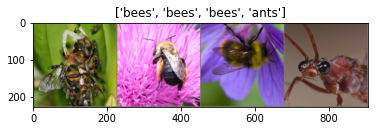

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6000 Acc: 0.6598
val Loss: 0.2176 Acc: 0.9085

Epoch 2/25
----------
train Loss: 0.5906 Acc: 0.7869
val Loss: 0.3775 Acc: 0.8562

Epoch 3/25
----------
train Loss: 0.4910 Acc: 0.7951
val Loss: 0.2949 Acc: 0.9020

Epoch 4/25
----------
train Loss: 0.5233 Acc: 0.8156
val Loss: 0.5639 Acc: 0.8105

Epoch 5/25
----------
train Loss: 0.4698 Acc: 0.7992
val Loss: 0.3354 Acc: 0.8758

Epoch 6/25
----------
train Loss: 0.4296 Acc: 0.8443
val Loss: 0.2740 Acc: 0.9412

Epoch 7/25
----------
train Loss: 0.6197 Acc: 0.7213
val Loss: 0.3513 Acc: 0.8366

Epoch 8/25
----------
train Loss: 0.3324 Acc: 0.8443
val Loss: 0.2382 Acc: 0.9216

Epoch 9/25
----------
train Loss: 0.3382 Acc: 0.8525
val Loss: 0.2469 Acc: 0.9150

Epoch 10/25
----------
train Loss: 0.3610 Acc: 0.8238
val Loss: 0.2295 Acc: 0.9281

Epoch 11/25
----------
train Loss: 0.3443 Acc: 0.8689
val Loss: 0.2458 Acc: 0.9150

Epoch 12/25
----------
train Loss: 0.3233 Acc: 0.8893
val Loss: 0.2345 Acc: 0.9346

E

## Results first training

````
Epoch 0/24
----------
train Loss: 0.6139 Acc: 0.7090
val Loss: 0.7355 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.7522 Acc: 0.7336
val Loss: 0.2959 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4526 Acc: 0.8197
val Loss: 0.2811 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.9025 Acc: 0.7828
val Loss: 0.4089 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5291 Acc: 0.8197
val Loss: 0.5416 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.5751 Acc: 0.7992
val Loss: 0.2944 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.5294 Acc: 0.7992
val Loss: 0.2939 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4904 Acc: 0.7992
val Loss: 0.2353 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3176 Acc: 0.8730
val Loss: 0.2340 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3149 Acc: 0.8607
val Loss: 0.2599 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2857 Acc: 0.8811
val Loss: 0.2584 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4230 Acc: 0.8279
val Loss: 0.2533 Acc: 0.9216

Epoch 12/24
----------
train Loss: 0.3517 Acc: 0.8607
val Loss: 0.2470 Acc: 0.9346

Epoch 13/24
----------
train Loss: 0.2343 Acc: 0.8934
val Loss: 0.2648 Acc: 0.9346

Epoch 14/24
----------
train Loss: 0.3310 Acc: 0.8607
val Loss: 0.2642 Acc: 0.9216

Epoch 15/24
----------
train Loss: 0.3216 Acc: 0.8893
val Loss: 0.2735 Acc: 0.9216

Epoch 16/24
----------
train Loss: 0.2386 Acc: 0.8975
val Loss: 0.2601 Acc: 0.9477

Epoch 17/24
----------
train Loss: 0.2713 Acc: 0.8730
val Loss: 0.2728 Acc: 0.9150

Epoch 18/24
----------
train Loss: 0.2359 Acc: 0.9139
val Loss: 0.2369 Acc: 0.9412

Epoch 19/24
----------
train Loss: 0.3297 Acc: 0.8484
val Loss: 0.2551 Acc: 0.9216

Epoch 20/24
----------
train Loss: 0.3162 Acc: 0.8607
val Loss: 0.2684 Acc: 0.9281

Epoch 21/24
----------
train Loss: 0.2691 Acc: 0.8811
val Loss: 0.2374 Acc: 0.9412

Epoch 22/24
----------
train Loss: 0.3422 Acc: 0.8443
val Loss: 0.2423 Acc: 0.9412

Epoch 23/24
----------
train Loss: 0.2749 Acc: 0.8770
val Loss: 0.2552 Acc: 0.9412

Epoch 24/24
----------
train Loss: 0.2636 Acc: 0.8934
val Loss: 0.2586 Acc: 0.9281

Training complete in 25m 39s
Best val Acc: 0.947712
````

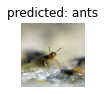

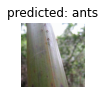

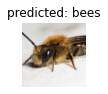

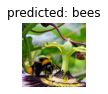

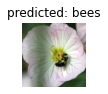

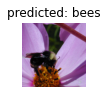

In [11]:
visualize_model(model_ft)

## ConvNet fixed feature extractor

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6550 Acc: 0.6434
val Loss: 0.3180 Acc: 0.8562

Epoch 2/25
----------
train Loss: 0.4637 Acc: 0.7746
val Loss: 0.4375 Acc: 0.7974

Epoch 3/25
----------
train Loss: 0.5029 Acc: 0.7828
val Loss: 0.1637 Acc: 0.9412

Epoch 4/25
----------
train Loss: 1.0026 Acc: 0.6352
val Loss: 0.1701 Acc: 0.9412

Epoch 5/25
----------
train Loss: 0.6921 Acc: 0.7705
val Loss: 0.1708 Acc: 0.9477

Epoch 6/25
----------
train Loss: 0.4591 Acc: 0.8402
val Loss: 0.4104 Acc: 0.8627

Epoch 7/25
----------
train Loss: 0.5035 Acc: 0.8074
val Loss: 0.1810 Acc: 0.9346

Epoch 8/25
----------
train Loss: 0.2929 Acc: 0.8852
val Loss: 0.1595 Acc: 0.9477

Epoch 9/25
----------
train Loss: 0.3521 Acc: 0.8484
val Loss: 0.1543 Acc: 0.9477

Epoch 10/25
----------
train Loss: 0.3164 Acc: 0.8770
val Loss: 0.1728 Acc: 0.9477

Epoch 11/25
----------
train Loss: 0.3529 Acc: 0.8484
val Loss: 0.1620 Acc: 0.9477

Epoch 12/25
----------
train Loss: 0.3209 Acc: 0.8607
val Loss: 0.1599 Acc: 0.9477

E

## First training results
````
Epoch 0/24
----------
train Loss: 0.9007 Acc: 0.6066
val Loss: 0.5421 Acc: 0.7320

Epoch 1/24
----------
train Loss: 0.5286 Acc: 0.7377
val Loss: 0.1722 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.6866 Acc: 0.7377
val Loss: 0.2155 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5096 Acc: 0.7869
val Loss: 0.2156 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4130 Acc: 0.8115
val Loss: 0.1669 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3851 Acc: 0.8156
val Loss: 0.3677 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.4341 Acc: 0.7951
val Loss: 0.1835 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3113 Acc: 0.8607
val Loss: 0.2036 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2612 Acc: 0.8893
val Loss: 0.2087 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3674 Acc: 0.8361
val Loss: 0.1790 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3929 Acc: 0.8033
val Loss: 0.1779 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3963 Acc: 0.8361
val Loss: 0.1877 Acc: 0.9346

Epoch 12/24
----------
train Loss: 0.3283 Acc: 0.8770
val Loss: 0.2062 Acc: 0.9150

Epoch 13/24
----------
train Loss: 0.3652 Acc: 0.8402
val Loss: 0.1736 Acc: 0.9477

Epoch 14/24
----------
train Loss: 0.3360 Acc: 0.8648
val Loss: 0.1881 Acc: 0.9281

Epoch 15/24
----------
train Loss: 0.3814 Acc: 0.8443
val Loss: 0.1863 Acc: 0.9412

Epoch 16/24
----------
train Loss: 0.3477 Acc: 0.8525
val Loss: 0.1900 Acc: 0.9346

Epoch 17/24
----------
train Loss: 0.3371 Acc: 0.8484
val Loss: 0.1790 Acc: 0.9477

Epoch 18/24
----------
train Loss: 0.3244 Acc: 0.8361
val Loss: 0.1937 Acc: 0.9281

Epoch 19/24
----------
train Loss: 0.3409 Acc: 0.8443
val Loss: 0.1967 Acc: 0.9346

Epoch 20/24
----------
train Loss: 0.3191 Acc: 0.8361
val Loss: 0.1787 Acc: 0.9346

Epoch 21/24
----------
train Loss: 0.3377 Acc: 0.8689
val Loss: 0.1888 Acc: 0.9412

Epoch 22/24
----------
train Loss: 0.4105 Acc: 0.8361
val Loss: 0.1783 Acc: 0.9412

Epoch 23/24
----------
train Loss: 0.3138 Acc: 0.8443
val Loss: 0.1878 Acc: 0.9216

Epoch 24/24
----------
train Loss: 0.2681 Acc: 0.8975
val Loss: 0.2140 Acc: 0.9150

Training complete in 11m 54s
Best val Acc: 0.947712
````

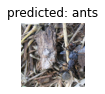

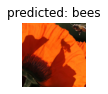

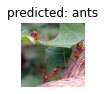

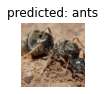

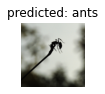

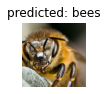

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()